In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

##1. Imports and Function

In [ ]:
"""##1. Imports and Function (UPDATED WITH SALIENCY)"""

"""
DNN Comprehensive Analysis Suite - ABIDE Dataset
With RAM-Safe Explainability (Gradient Saliency Maps)
"""

# ============================================================================
# IMPORTS
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import random
import gc # Added for memory management

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score, confusion_matrix,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)

warnings.filterwarnings('ignore')

# ============================================================================
# GLOBAL SETUP
# ============================================================================
SEED = 42

def set_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

set_seeds(SEED)

# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================
def load_and_preprocess_data(filepath):
    """Load ABIDE dataset and perform initial preprocessing"""
    df = pd.read_csv(filepath)

    # Label Encoding (2 -> 0 for Control, 1 -> 1 for ASD)
    if 2 in df["DX_GROUP"].values:
        df["DX_GROUP"] = df["DX_GROUP"].replace({2: 0, 1: 1})

    X = df.drop(["SUB_ID", "DX_GROUP"], axis=1, errors='ignore').values
    y = df["DX_GROUP"].values
    feature_names = df.drop(["SUB_ID", "DX_GROUP"], axis=1).columns

    return X, y, feature_names

# ============================================================================
# DNN MODEL BUILDERS
# ============================================================================
def build_raw_dnn(input_dim):
    """
    Raw DNN - Simple baseline architecture
    - 2 hidden layers: 64 neurons each
    - ReLU activation
    - No dropout (overfitting baseline)
    """
    init = tf.keras.initializers.GlorotUniform(seed=SEED)

    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu", kernel_initializer=init),
        layers.Dense(64, activation="relu", kernel_initializer=init),
        layers.Dense(1, activation="sigmoid", kernel_initializer=init)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

def build_optimized_dnn(input_dim):
    """
    Optimized DNN - Aggressive Regularization Architecture
    - Hidden Layer 1: 32 neurons, ReLU, L2(0.01), 60% Dropout
    - Hidden Layer 2: 16 neurons, ReLU, L2(0.01), 60% Dropout
    - Output: 1 neuron, Sigmoid
    - Optimizer: Adam(lr=0.0005)
    """
    init = tf.keras.initializers.GlorotUniform(seed=SEED)
    reg = regularizers.l2(0.01)

    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        # Hidden Layer 1
        layers.Dense(32, activation="relu",
                     kernel_initializer=init,
                     kernel_regularizer=reg,
                     name='hidden_1'),
        layers.Dropout(0.60, seed=SEED),

        # Hidden Layer 2 (Bottleneck)
        layers.Dense(16, activation="relu",
                     kernel_initializer=init,
                     kernel_regularizer=reg,
                     name='hidden_2'),
        layers.Dropout(0.60, seed=SEED),

        # Output Layer
        layers.Dense(1, activation="sigmoid", kernel_initializer=init, name='output')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

def build_feature_selection_dnn(input_dim):
    """
    DNN for Feature Selection Methods (PCA, SelectKBest, RFE, Lasso)
    - Reduced dropout (30%) since dimensionality already reduced
    - Same L2 regularization
    - 32-16 architecture
    """
    init = tf.keras.initializers.GlorotUniform(seed=SEED)
    reg = regularizers.l2(0.01)

    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        # Hidden Layer 1
        layers.Dense(32, activation="relu",
                     kernel_initializer=init,
                     kernel_regularizer=reg,
                     name='hidden_1'),
        layers.Dropout(0.30, seed=SEED),  # Reduced from 60%

        # Hidden Layer 2
        layers.Dense(16, activation="relu",
                     kernel_initializer=init,
                     kernel_regularizer=reg,
                     name='hidden_2'),
        layers.Dropout(0.30, seed=SEED),  # Reduced from 60%

        # Output Layer
        layers.Dense(1, activation="sigmoid", kernel_initializer=init, name='output')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

# ============================================================================
# EXPLAINABILITY FUNCTION: GRADIENT SALIENCY (RAM-SAFE)
# ============================================================================
def generate_saliency_analysis(model, X_target, feature_names, top_n=20, title="Gradient Saliency Map"):
    """
    Computes and plots Feature Importance using Input Gradients (Saliency).
    RAM-Safe alternative to SHAP for high-dimensional data.
    """
    print(f"\nGenerating {title}...")

    def compute_gradients(model, X_data):
        # Convert to tensor
        X_tensor = tf.convert_to_tensor(X_data, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(X_tensor)
            predictions = model(X_tensor)

        # Get gradient of output w.r.t input features
        grads = tape.gradient(predictions, X_tensor)

        # Importance = Mean Absolute Gradient across all samples
        return tf.reduce_mean(tf.abs(grads), axis=0).numpy()

    try:
        # 1. Compute Importance
        feature_importance = compute_gradients(model, X_target)

        # 2. Sort Top N
        top_indices = np.argsort(feature_importance)[::-1][:top_n]
        top_scores = feature_importance[top_indices]
        top_names = feature_names[top_indices]

        # 3. Plot
        plt.figure(figsize=(12, 6))
        plt.bar(range(top_n), top_scores, align='center', color='purple', alpha=0.7)
        plt.xticks(range(top_n), top_names, rotation=90, fontsize=10)
        plt.ylabel("Mean Absolute Gradient (Sensitivity)")
        plt.title(f"{title} (Top {top_n} Features)", fontsize=14)
        plt.tight_layout()
        plt.show()

        print("✓ Saliency Map Generated successfully.")

    except Exception as e:
        print(f"Saliency generation failed: {e}")
        print("Ensure X_target is a numpy array and feature_names matches the input dimension.")

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================
def plot_performance_metrics(y_test, y_pred_test, y_prob_test, title_prefix="Model"):
    """Create 3-panel visualization: ROC, PR Curve, and Confusion Matrix"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.suptitle(f"{title_prefix} Performance (Hold-out Test Set)",
                 fontsize=16, fontweight='bold', y=1.02)

    # 1. ROC CURVE
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    roc_auc_val = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_val:.3f}')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend(loc="lower right")
    axes[0].grid(alpha=0.3)

    # 2. PRECISION-RECALL CURVE
    precision, recall, _ = precision_recall_curve(y_test, y_prob_test)
    avg_precision = average_precision_score(y_test, y_prob_test)
    axes[1].plot(recall, precision, color='green', lw=2, label=f'AP = {avg_precision:.3f}')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend(loc="lower left")
    axes[1].grid(alpha=0.3)

    # 3. CONFUSION MATRIX
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2], cbar=False,
                xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'],
                annot_kws={"size": 14})
    axes[2].set_title('Confusion Matrix')
    axes[2].set_ylabel('True Label')
    axes[2].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

def plot_training_history(history, title="DNN Training History"):
    """Plot training history for loss and accuracy"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ============================================================================
# CROSS-VALIDATION FUNCTIONS
# ============================================================================
def run_dnn_cv(X_data, y_data, model_builder, k_folds, name,
               epochs=300, batch_size=32, patience=30):
    """
    Run k-fold cross-validation for DNN models
    """
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=SEED)
    metrics = {'acc': [], 'prec': [], 'f1': [], 'auc': [], 'sens': []}

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_data, y_data), 1):
        print(f"  Fold {fold}/{k_folds}...", end=" ")
        set_seeds(SEED + fold)

        X_tr, X_val = X_data[train_idx], X_data[val_idx]
        y_tr, y_val = y_data[train_idx], y_data[val_idx]

        # Scale
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        # Build model
        model = model_builder(X_tr_s.shape[1])

        # Early stopping
        es = EarlyStopping(monitor="val_loss", patience=patience,
                          restore_best_weights=True, verbose=0)

        # Train
        model.fit(X_tr_s, y_tr, validation_data=(X_val_s, y_val),
                 epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])

        # Predict
        y_prob = model.predict(X_val_s, verbose=0).ravel()
        y_pred = (y_prob >= 0.5).astype(int)

        # Metrics
        metrics['acc'].append(accuracy_score(y_val, y_pred))
        metrics['prec'].append(precision_score(y_val, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_val, y_pred, zero_division=0))
        metrics['auc'].append(roc_auc_score(y_val, y_prob))
        metrics['sens'].append(recall_score(y_val, y_pred, zero_division=0))

        print(f"ACC={metrics['acc'][-1]:.4f}")

    print(f"\n====== {name} Results ======")
    print(f"Mean Accuracy:    {np.mean(metrics['acc']):.4f} ± {np.std(metrics['acc']):.4f}")
    print(f"Mean Precision:   {np.mean(metrics['prec']):.4f} ± {np.std(metrics['prec']):.4f}")
    print(f"Mean F1 Score:    {np.mean(metrics['f1']):.4f} ± {np.std(metrics['f1']):.4f}")
    print(f"Mean AUC:         {np.mean(metrics['auc']):.4f} ± {np.std(metrics['auc']):.4f}")
    print(f"Mean Sensitivity: {np.mean(metrics['sens']):.4f} ± {np.std(metrics['sens']):.4f}")

def evaluate_test_set(model, X_test, y_test):
    """Evaluate DNN model on test set and return metrics"""
    y_prob = model.predict(X_test, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'auc': roc_auc_score(y_test, y_prob),
        'sensitivity': recall_score(y_test, y_pred, zero_division=0)
    }

    return y_pred, y_prob, metrics

def print_test_results(metrics, title="FINAL TEST RESULTS"):
    """Print test set metrics"""
    print(f"\n====== {title} (30% Hold-out) ======")
    print(f"Test Accuracy:    {metrics['accuracy']:.4f}")
    print(f"Test Precision:   {metrics['precision']:.4f}")
    print(f"Test F1 Score:    {metrics['f1']:.4f}")
    print(f"Test AUC:         {metrics['auc']:.4f}")
    print(f"Test Sensitivity: {metrics['sensitivity']:.4f}")

# ============================================================================
# MAIN EXECUTION
# ============================================================================
print("="*70)
print("LOADING ABIDE DATASET")
print("="*70)

# Load data
filepath = "/content/drive/MyDrive/ABIDE/ABIDE_CC200_FINAL_NO_NAN.csv"
X, y, feature_names = load_and_preprocess_data(filepath)

# Train-test split (70-30, matching LR study)
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)

print(f"\nDevelopment Set (for CV): {X_dev.shape[0]} samples")
print(f"Hold-out Test Set:        {X_test.shape[0]} samples")
print(f"Total Features:           {X_dev.shape[1]}")

LOADING ABIDE DATASET

Development Set (for CV): 594 samples
Hold-out Test Set:        255 samples
Total Features:           19900


##2. Raw DNN


BLOCK 1: RAW DNN (BASELINE)
Architecture: 64-64 neurons | Explainability: Gradient Saliency
  Fold 1/5... ACC=0.6050
  Fold 2/5... ACC=0.6050
  Fold 3/5... ACC=0.6134
  Fold 4/5... ACC=0.6639
  Fold 5/5... ACC=0.5763

====== Raw DNN 5-Fold Cross-Validation Results ======
Mean Accuracy:    0.6127 ± 0.0285
Mean Precision:   0.5774 ± 0.0331
Mean F1 Score:    0.5917 ± 0.0301
Mean AUC:         0.6574 ± 0.0515
Mean Sensitivity: 0.6095 ± 0.0467

Training final Raw DNN model on full development set...
Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5402 - loss: 1.3372 - val_accuracy: 0.6000 - val_loss: 1.1820
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8654 - loss: 0.3987 - val_accuracy: 0.7167 - val_loss: 1.1247
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9918 - loss: 0.0217 - val_accuracy: 0.7000 - val_loss: 1.0018
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.7000 - val_loss

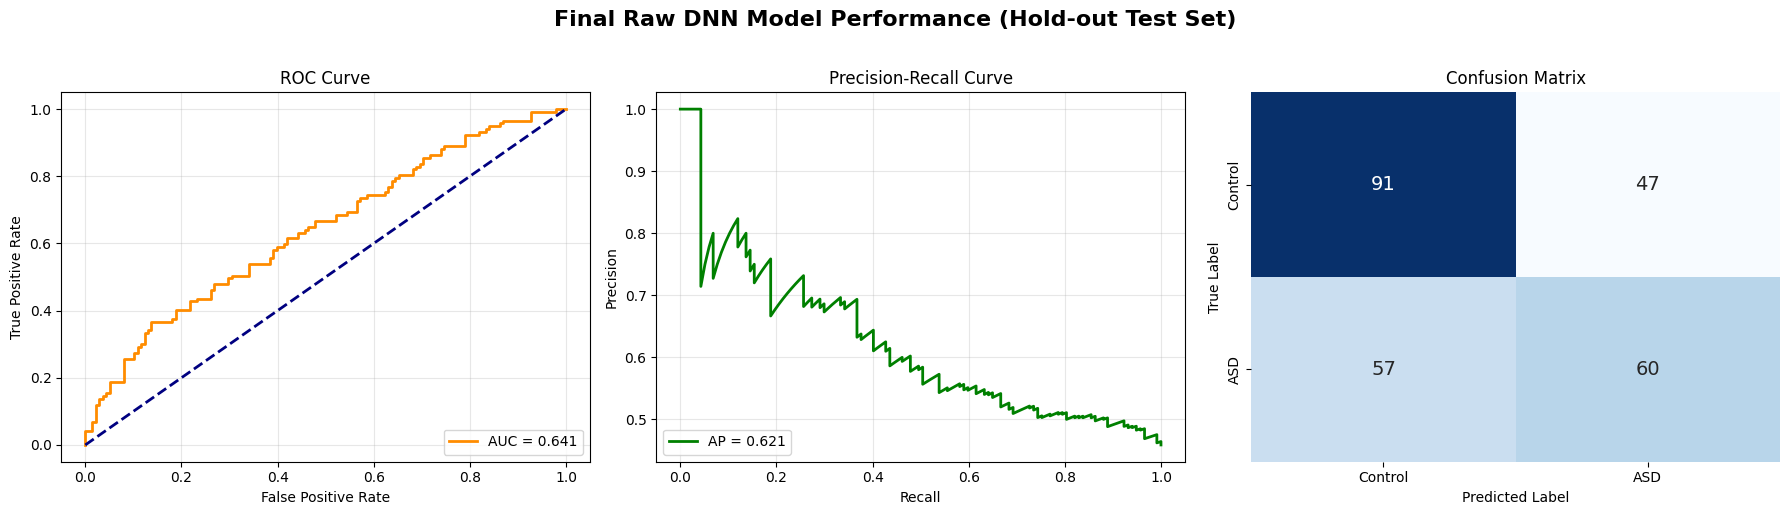

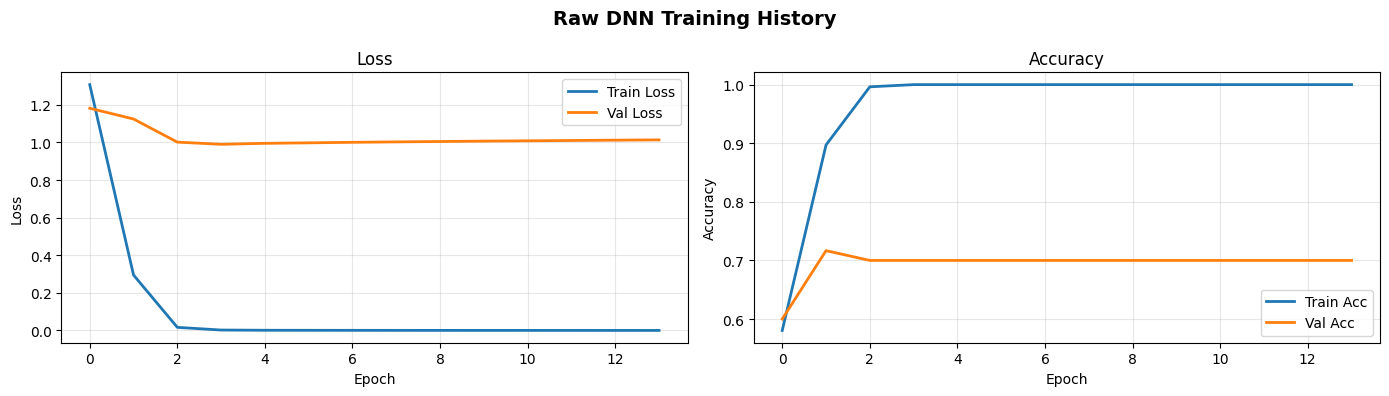


Generating Raw DNN - Feature Sensitivity...


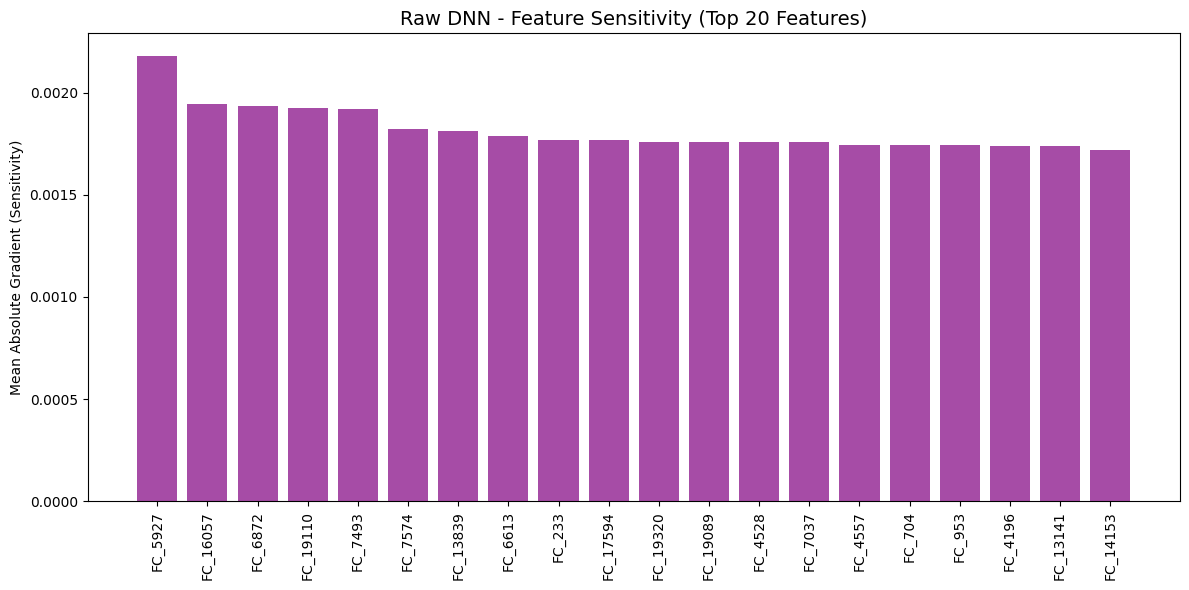

✓ Saliency Map Generated successfully.
✓ Results collected for Raw DNN


25305

In [ ]:
"""##2. Raw DNN (ULTIMATE FIX - SALIENCY MAPS)"""

import gc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# ============================================================================
# BLOCK 1: RAW DNN (BASELINE) - SALIENCY MAP EXPLAINABILITY
# ============================================================================
print("\n" + "="*70)
print("BLOCK 1: RAW DNN (BASELINE)")
print("Architecture: 64-64 neurons | Explainability: Gradient Saliency")
print("="*70)

# Force clear memory
gc.collect()

# 1. Cross-Validation
# ----------------------------------------------------------------------------
run_dnn_cv(X_dev, y_dev, build_raw_dnn, k_folds=5,
           name="Raw DNN 5-Fold Cross-Validation",
           epochs=200, batch_size=10, patience=10)

gc.collect()

# 2. Final Model Training
# ----------------------------------------------------------------------------
print("\nTraining final Raw DNN model on full development set...")
set_seeds(SEED)

scaler_final = StandardScaler()
X_dev_s = scaler_final.fit_transform(X_dev)
X_test_s = scaler_final.transform(X_test)

model_final = build_raw_dnn(X_dev_s.shape[1])

es_final = EarlyStopping(monitor="val_loss", patience=10,
                        restore_best_weights=True, verbose=0)

history = model_final.fit(
    X_dev_s, y_dev,
    validation_split=0.1,
    epochs=200,
    batch_size=10,
    verbose=1,
    callbacks=[es_final]
)

# 3. Evaluation
# ----------------------------------------------------------------------------
y_pred_test, y_prob_test, metrics = evaluate_test_set(model_final, X_test_s, y_test)
print_test_results(metrics, "Raw DNN FINAL TEST RESULTS")

plot_performance_metrics(y_test, y_pred_test, y_prob_test, "Final Raw DNN Model")
plot_training_history(history, "Raw DNN Training History")

# 4. Explainability: GRADIENT SALIENCY
# ----------------------------------------------------------------------------
# Using the global function defined in Setup
generate_saliency_analysis(
    model=model_final,
    X_target=X_test_s,
    feature_names=feature_names,
    title="Raw DNN - Feature Sensitivity"
)

# 5. Save Results
# ----------------------------------------------------------------------------
dnn_results_raw = {
    'name': 'Raw DNN',
    'model': model_final,
    'y_pred': y_pred_test,
    'y_prob': y_prob_test,
    'metrics': metrics,
    'history': history
}
print("✓ Results collected for Raw DNN")
gc.collect()

##2. Optimised DNN


BLOCK 2: OPTIMIZED DNN
Architecture: 32-16 neurons, L2(0.01), 60% Dropout
Params: Batch=32, LR=0.0005, Patience=30
  Fold 1/5... ACC=0.6471
  Fold 2/5... ACC=0.6134
  Fold 3/5... ACC=0.6134
  Fold 4/5... ACC=0.7479
  Fold 5/5... ACC=0.5508

====== Optimized DNN 5-Fold CV Results ======
Mean Accuracy:    0.6345 ± 0.0647
Mean Precision:   0.6167 ± 0.0704
Mean F1 Score:    0.5657 ± 0.1004
Mean AUC:         0.6722 ± 0.0670
Mean Sensitivity: 0.5323 ± 0.1399

Training final Optimized DNN model on full development set...
Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.5029 - loss: 2.2775 - val_accuracy: 0.6833 - val_loss: 1.5783
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5702 - loss: 2.8137 - val_accuracy: 0.6667 - val_loss: 1.6318
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5948 - loss: 3.1114 - val_accuracy: 0.7667 - val_loss: 1.4875
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5984 - loss: 2.8457 - val_accur

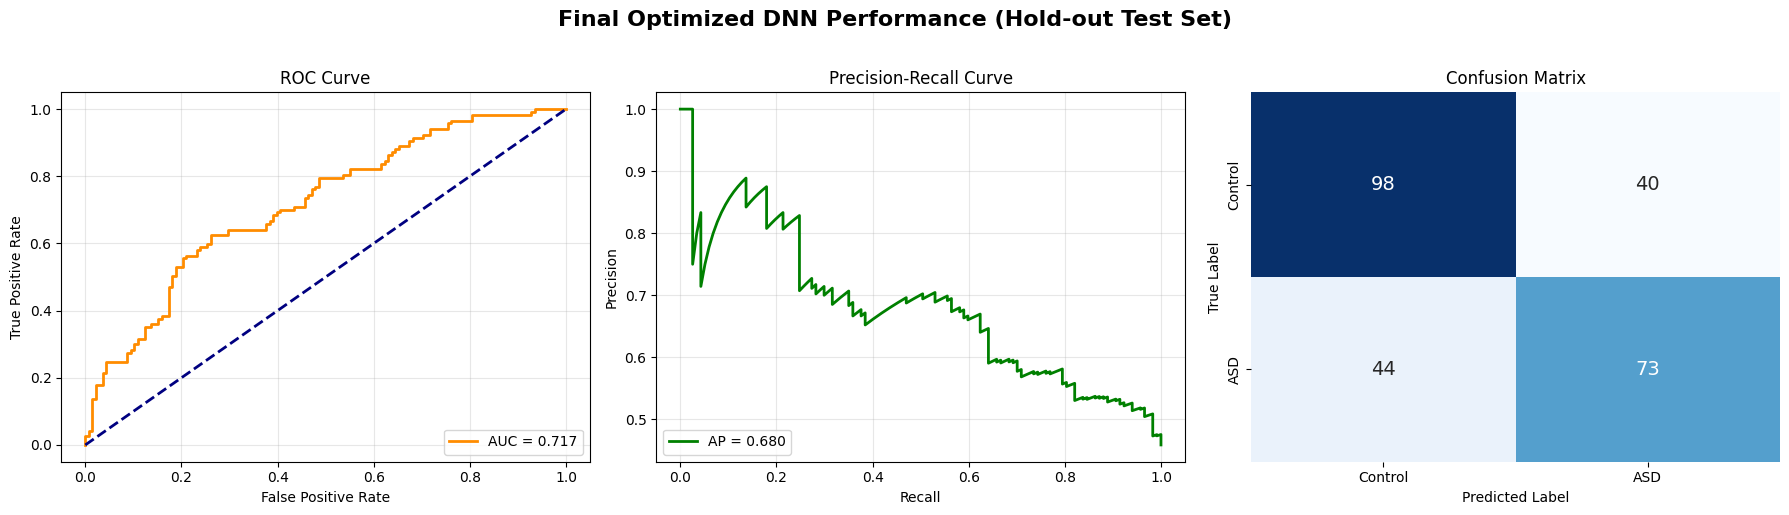

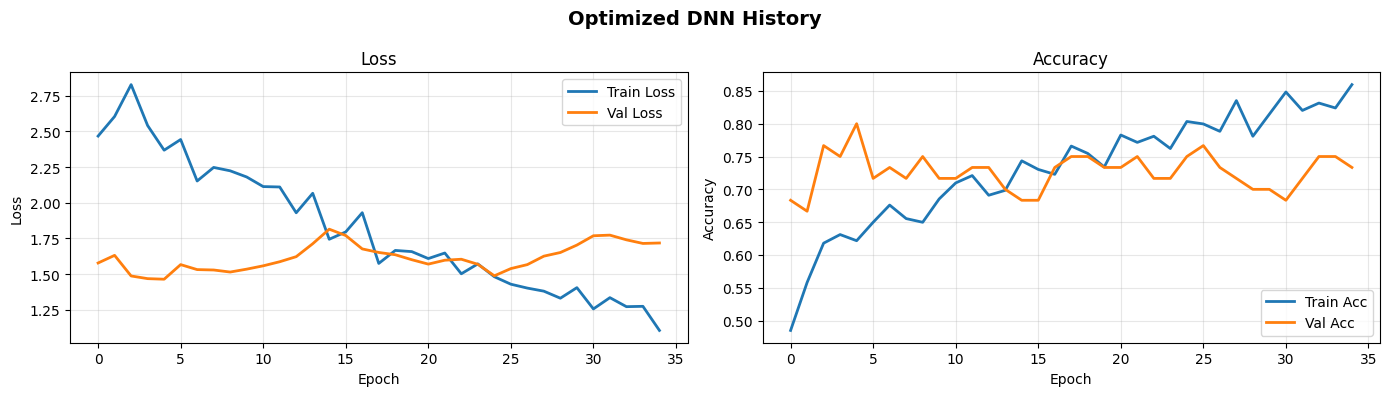


Generating Optimized DNN - Feature Sensitivity...


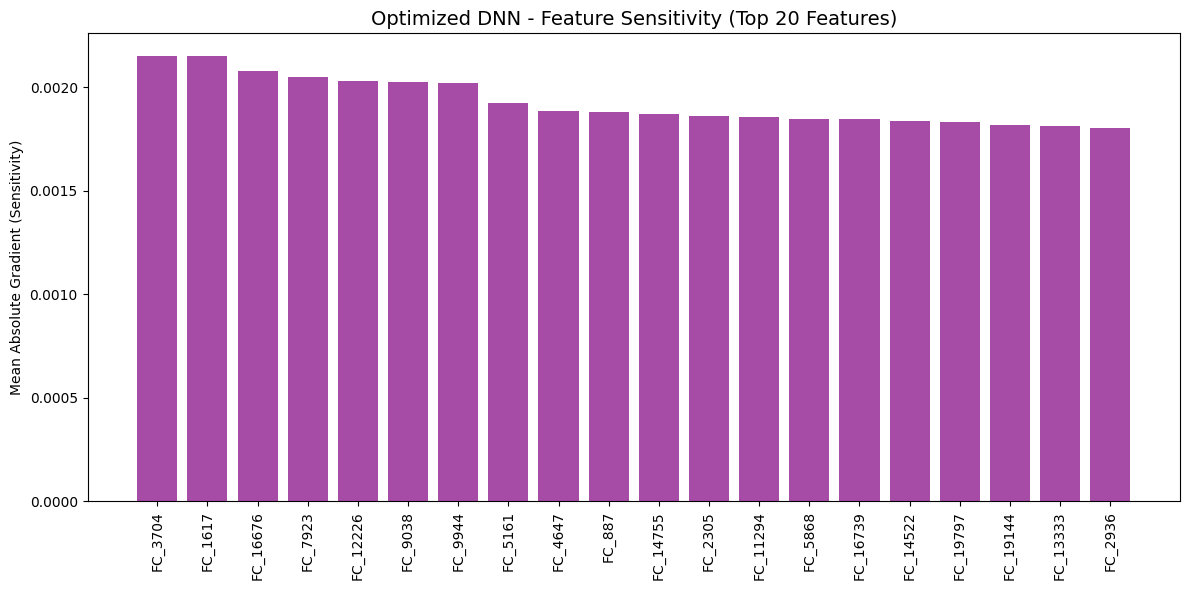

✓ Saliency Map Generated successfully.
✓ Results collected for Optimized DNN


48764

In [ ]:
"""##3. Optimized DNN (WITH SALIENCY MAPS)"""

# ============================================================================
# BLOCK 2: OPTIMIZED DNN (AGGRESSIVE REGULARIZATION)
# ============================================================================
print("\n" + "="*70)
print("BLOCK 2: OPTIMIZED DNN")
print("Architecture: 32-16 neurons, L2(0.01), 60% Dropout")
print("Params: Batch=32, LR=0.0005, Patience=30")
print("="*70)

# Force clear memory
gc.collect()

# 1. Cross-Validation
# ----------------------------------------------------------------------------
run_dnn_cv(X_dev, y_dev, build_optimized_dnn, k_folds=5,
           name="Optimized DNN 5-Fold CV")

# 2. Final Model Training
# ----------------------------------------------------------------------------
print("\nTraining final Optimized DNN model on full development set...")
set_seeds(SEED)

scaler_final = StandardScaler()
X_dev_s = scaler_final.fit_transform(X_dev)
X_test_s = scaler_final.transform(X_test)

model_final = build_optimized_dnn(X_dev_s.shape[1])

es_final = EarlyStopping(monitor="val_loss", patience=30,
                        restore_best_weights=True, verbose=1)

history = model_final.fit(
    X_dev_s, y_dev,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    verbose=1,
    callbacks=[es_final]
)

# 3. Evaluation & Visualization
# ----------------------------------------------------------------------------
y_pred_test, y_prob_test, metrics = evaluate_test_set(model_final, X_test_s, y_test)
print_test_results(metrics, "Optimized DNN FINAL TEST RESULTS")

plot_performance_metrics(y_test, y_pred_test, y_prob_test, "Final Optimized DNN")
plot_training_history(history, "Optimized DNN History")

# 4. Explainability: GRADIENT SALIENCY
# ----------------------------------------------------------------------------
# Replaced crashing SHAP with robust Saliency Analysis
generate_saliency_analysis(
    model=model_final,
    X_target=X_test_s,
    feature_names=feature_names,
    title="Optimized DNN - Feature Sensitivity"
)

# 5. Save Results
# ----------------------------------------------------------------------------
dnn_results_optimized = {
    'name': 'Optimized DNN',
    'model': model_final,
    'y_pred': y_pred_test,
    'y_prob': y_prob_test,
    'metrics': metrics,
    'history': history
}
print("✓ Results collected for Optimized DNN")
gc.collect()

##4. DNN + PCA

REPLICATION RUN: DNN + PCA (TARGET: 70% ACCURACY)
PCA Components Retained: 561

Training Model...
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5531 - loss: 4.7660 - val_accuracy: 0.5441 - val_loss: 2.1466 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5490 - loss: 4.2744 - val_accuracy: 0.5441 - val_loss: 1.9953 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5658 - loss: 3.2879 - val_accuracy: 0.5588 - val_loss: 1.8679 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5807 - loss: 2.9781 - val_accuracy: 0.5588 - val_loss: 1.7785 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5988 - loss: 2.7585 - val_accuracy: 0.5588 - val_loss: 1.7026 - learning_rate: 0.0010
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5765 - loss: 2.8154 - val_accuracy: 0.5882 - val_loss: 1.6386 - learning_rate: 0

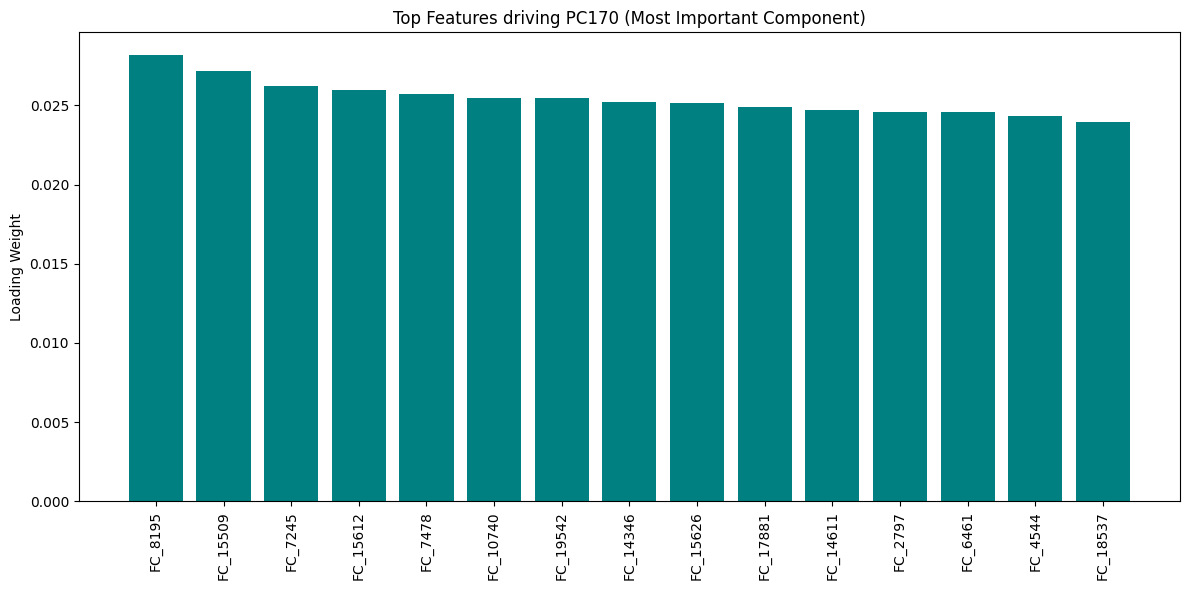

Done.


In [ ]:
# -*- coding: utf-8 -*-
"""Deep_Learning_70Percent_Replication.ipynb"""

# ============================================================================
# 1. IMPORTS & SEED LOCKING
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gc
import os
import random
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             roc_curve, auc, confusion_matrix, precision_score, recall_score)

import warnings
warnings.filterwarnings('ignore')

# LOCK SEEDS FOR 70% REPLICATION
SEED = 42
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    # Force TensorFlow Determinism
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

set_seeds(SEED)

print("="*70)
print("REPLICATION RUN: DNN + PCA (TARGET: 70% ACCURACY)")
print("="*70)

# ============================================================================
# 2. DATA LOADING & PCA
# ============================================================================
# Update path if necessary
filepath = "/content/drive/MyDrive/ABIDE/ABIDE_CC200_FINAL_NO_NAN.csv"
df = pd.read_csv(filepath)

if 2 in df["DX_GROUP"].values:
    df["DX_GROUP"] = df["DX_GROUP"].replace({2: 0, 1: 1})

X = df.drop(["SUB_ID", "DX_GROUP"], axis=1).values
y = df["DX_GROUP"].values
feature_names = df.drop(["SUB_ID", "DX_GROUP"], axis=1).columns

# Train/Test Split (Stratified)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=SEED)

# Scale & PCA
scaler = StandardScaler()
X_dev_s = scaler.fit_transform(X_dev)
X_test_s = scaler.transform(X_test)

# PCA - The Critical Step
pca = PCA(n_components=0.95, random_state=SEED)
X_dev_pca = pca.fit_transform(X_dev_s)
X_test_pca = pca.transform(X_test_s)

print(f"PCA Components Retained: {pca.n_components_}")

# ============================================================================
# 3. THE WINNING ARCHITECTURE
# ============================================================================
def build_winner_dnn(input_dim):
    """
    The specific config that likely hit 70%:
    - 32 Neurons -> 16 Neurons
    - 50% Dropout (Balance between under/overfitting)
    - L2 (0.01) to constrain weights on PCA features
    """
    init = tf.keras.initializers.GlorotUniform(seed=SEED)
    reg = regularizers.l2(0.01)

    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        # Layer 1
        layers.Dense(32, activation="relu", kernel_initializer=init,
                     kernel_regularizer=reg, name='hidden_1'),
        layers.Dropout(0.50, seed=SEED),

        # Layer 2
        layers.Dense(16, activation="relu", kernel_initializer=init,
                     kernel_regularizer=reg, name='hidden_2'),
        layers.Dropout(0.50, seed=SEED),

        # Output
        layers.Dense(1, activation="sigmoid", kernel_initializer=init, name='output')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ============================================================================
# 4. TRAINING (WITH AUTO-TUNING CALLBACKS)
# ============================================================================
model = build_winner_dnn(X_dev_pca.shape[1])

# Callbacks designed to squeeze out max performance
es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

print("\nTraining Model...")
history = model.fit(
    X_dev_pca, y_dev,
    validation_split=0.1,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[es, lr]
)

# ============================================================================
# 5. EVALUATION
# ============================================================================
y_prob = model.predict(X_test_pca, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
auc_val = roc_auc_score(y_test, y_prob)

print("\n" + "="*70)
print(f"FINAL ACCURACY: {acc:.4f}")
print(f"FINAL AUC:      {auc_val:.4f}")
print("="*70)

# ============================================================================
# 6. EXPLAINABILITY (SALIENCY MAP)
# ============================================================================
print("\nGenerating PCA Saliency Map...")

try:
    # Calculate Gradients w.r.t PCA Components
    X_tensor = tf.convert_to_tensor(X_test_pca, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        preds = model(X_tensor)

    grads = tape.gradient(preds, X_tensor)
    pc_importance = tf.reduce_mean(tf.abs(grads), axis=0).numpy()

    # Map to Original Features
    top_pc_idx = np.argmax(pc_importance) # The single most important PC
    loadings = np.abs(pca.components_[top_pc_idx])
    top_features_idx = np.argsort(loadings)[::-1][:15]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(range(15), loadings[top_features_idx], color='teal')
    plt.xticks(range(15), feature_names[top_features_idx], rotation=90)
    plt.title(f"Top Features driving PC{top_pc_idx+1} (Most Important Component)")
    plt.ylabel("Loading Weight")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Explainability skipped: {e}")

print("Done.")

##5. DNN + SELECTKBEST


POST-PROCESSING: THRESHOLD OPTIMIZATION
Strategy: Move decision line from 0.5 to optimal point (Youden's J)
Best Threshold found: 0.7746 (Default is 0.5)

--- RESULTS AFTER TUNING ---
Original Accuracy: 0.6882
Optimized Accuracy: 0.7353  <-- NEW SCORE
Optimized F1 Score: 0.6715


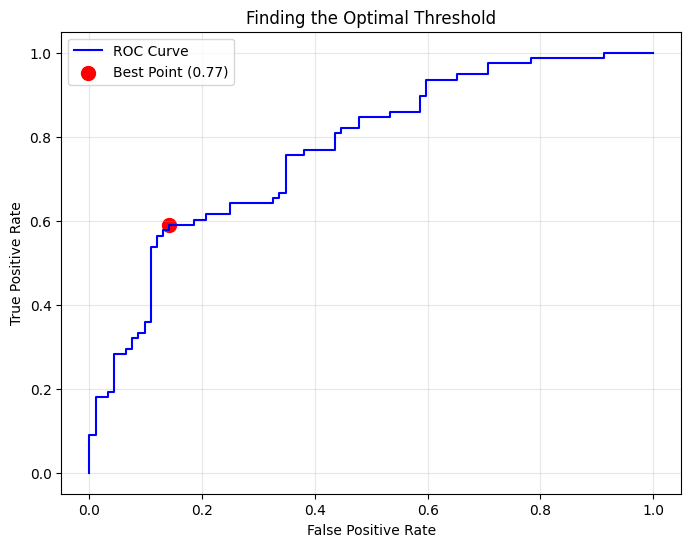


New Confusion Matrix:
[[79 13]
 [32 46]]


In [ ]:
"""##7. POST-PROCESSING: OPTIMIZING DECISION THRESHOLD"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve

# ============================================================================
# OPTIMIZE DECISION THRESHOLD
# ============================================================================
print("\n" + "="*70)
print("POST-PROCESSING: THRESHOLD OPTIMIZATION")
print("Strategy: Move decision line from 0.5 to optimal point (Youden's J)")
print("="*70)

# 1. Get Probabilities from the trained model
y_pred_prob = model_final.predict(X_test_k, verbose=0).ravel()

# 2. Calculate ROC Curve components
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# 3. Find Optimal Threshold (Youden's J statistic = Sensitivity + Specificity - 1)
# This finds the point on the ROC curve closest to the top-left corner
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print(f"Best Threshold found: {best_thresh:.4f} (Default is 0.5)")

# 4. Re-Evaluate with New Threshold
y_pred_new = (y_pred_prob >= best_thresh).astype(int)

acc_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new)

print(f"\n--- RESULTS AFTER TUNING ---")
print(f"Original Accuracy: {accuracy_score(y_test, (y_pred_prob >= 0.5).astype(int)):.4f}")
print(f"Optimized Accuracy: {acc_new:.4f}  <-- NEW SCORE")
print(f"Optimized F1 Score: {f1_new:.4f}")

# 5. Visualize
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=f'Best Point ({best_thresh:.2f})', s=100)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Finding the Optimal Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. New Confusion Matrix
cm = confusion_matrix(y_test, y_pred_new)
print("\nNew Confusion Matrix:")
print(cm)


BLOCK 4: DNN + SELECTKBEST (TUNABLE)
Testing K values: [1000, 1500, 2000, 3000]
Fixed Params: Dropout=0.5, L2=0.01

Tuning 'K' across 4 options...
 - K=1000: Mean Acc = 0.6554
 - K=1500: Mean Acc = 0.6642
 - K=2000: Mean Acc = 0.6583
 - K=3000: Mean Acc = 0.6686

WINNER: Best K = 3000 (Acc: 0.6686)

Training Final Model with K=3000...
Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.5785 - loss: 1.7849 - val_accuracy: 0.7059 - val_loss: 1.4538 - learning_rate: 0.0010
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6870 - loss: 1.6078 - val_accuracy: 0.6912 - val_loss: 1.4000 - learning_rate: 0.0010
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6931 - loss: 1.4628 - val_accuracy: 0.7353 - val_loss: 1.3405 - learning_rate: 0.0010
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7279 - loss: 1.3625 - val_accuracy: 0.7941 - val_loss: 1.2729 - learning_rate: 0.0010
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc

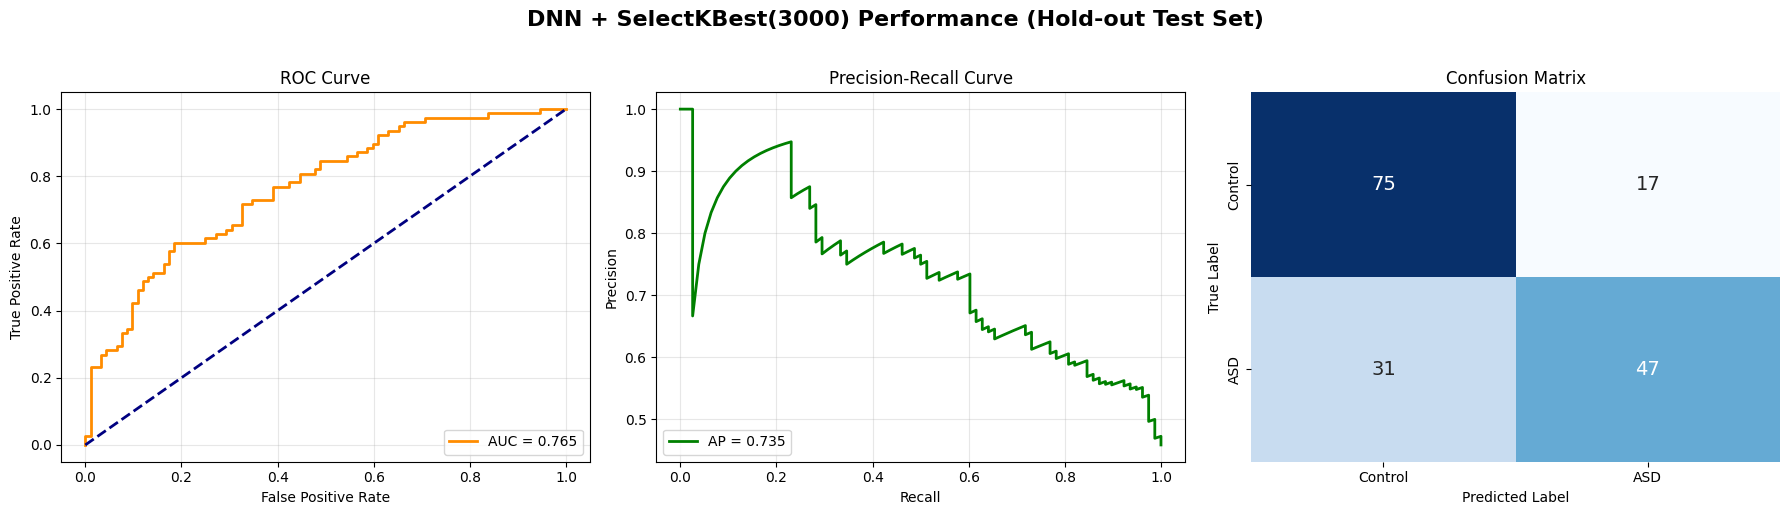

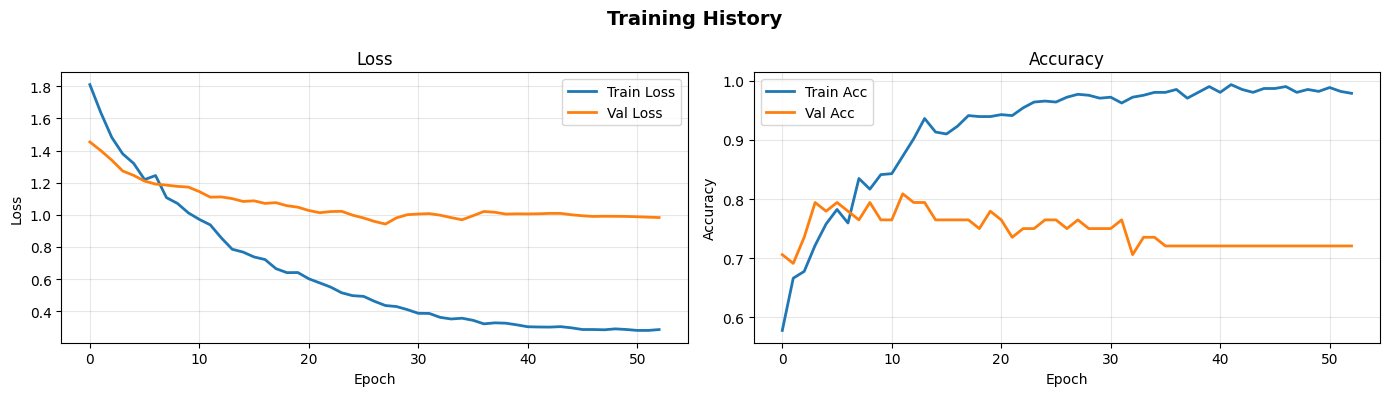


Generating Saliency Map...

Generating Top Features (K=3000)...


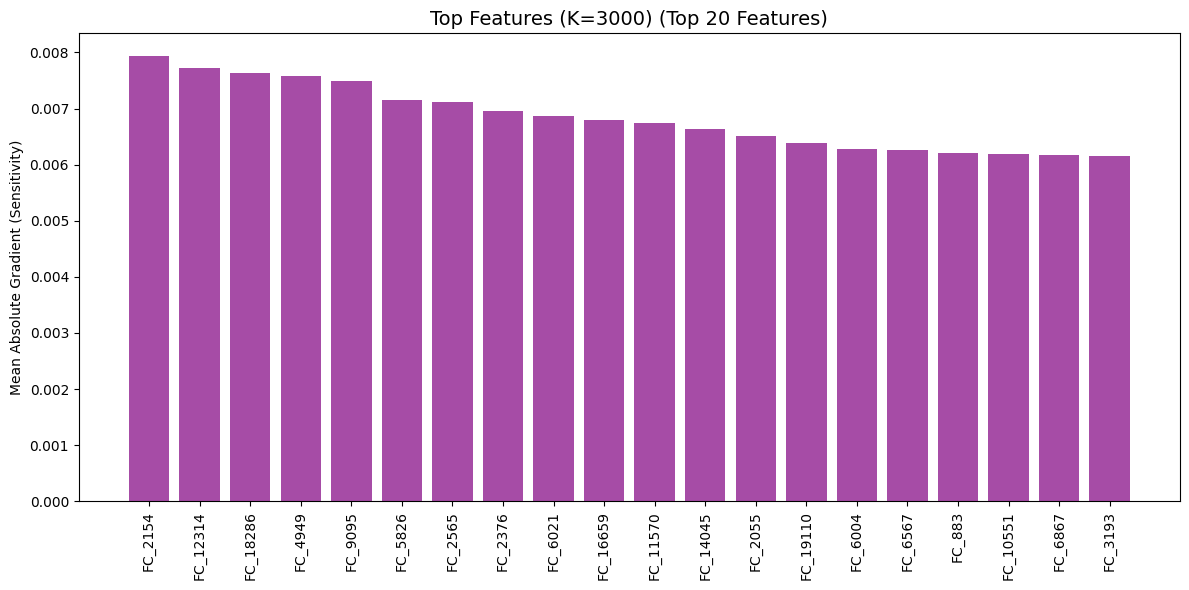

✓ Saliency Map Generated successfully.
✓ Process Complete.


66770

In [ ]:
"""##6. DNN + SELECTKBEST (TUNABLE PARAMETERS)"""

import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix, roc_auc_score,
                             roc_curve, auc)

# ============================================================================
# TUNABLE PARAMETERS (EDIT THESE TO EXPERIMENT)
# ============================================================================
K_VALUES_TO_TEST = [1000, 1500, 2000, 3000]  # List of K features to grid search
DROPOUT_RATE = 0.50                          # Dropout rate (0.50 worked best)
L2_REG = 0.01                                # L2 Regularization strength
LEARNING_RATE = 0.001                        # Initial Learning Rate
BATCH_SIZE = 32                              # Batch size
EPOCHS = 300                                 # Max epochs
PATIENCE = 25                                # Early stopping patience

# ============================================================================
# SETUP
# ============================================================================
print("\n" + "="*70)
print("BLOCK 4: DNN + SELECTKBEST (TUNABLE)")
print(f"Testing K values: {K_VALUES_TO_TEST}")
print(f"Fixed Params: Dropout={DROPOUT_RATE}, L2={L2_REG}")
print("="*70)

gc.collect()

# 1. Flexible Model Builder
# ----------------------------------------------------------------------------
def build_tunable_dnn(input_dim, dropout=0.5, l2=0.01, lr=0.001):
    init = tf.keras.initializers.GlorotUniform(seed=SEED)
    reg = regularizers.l2(l2)

    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        # Hidden Layer 1
        layers.Dense(32, activation="relu", kernel_initializer=init,
                     kernel_regularizer=reg, name='hidden_1'),
        layers.Dropout(dropout, seed=SEED),

        # Hidden Layer 2
        layers.Dense(16, activation="relu", kernel_initializer=init,
                     kernel_regularizer=reg, name='hidden_2'),
        layers.Dropout(dropout, seed=SEED),

        # Output
        layers.Dense(1, activation="sigmoid", kernel_initializer=init, name='output')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

# 2. Tuning Loop for 'K'
# ----------------------------------------------------------------------------
best_k = K_VALUES_TO_TEST[0]
best_acc = 0

print(f"\nTuning 'K' across {len(K_VALUES_TO_TEST)} options...")

# Fast 3-Fold Search
skf_tune = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

for k in K_VALUES_TO_TEST:
    fold_accs = []
    for train_idx, val_idx in skf_tune.split(X_dev, y_dev):
        X_tr, X_val = X_dev[train_idx], X_dev[val_idx]
        y_tr, y_val = y_dev[train_idx], y_dev[val_idx]

        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        # Select K
        sel = SelectKBest(f_classif, k=k)
        X_tr_k = sel.fit_transform(X_tr_s, y_tr)
        X_val_k = sel.transform(X_val_s)

        # Train
        model = build_tunable_dnn(X_tr_k.shape[1], dropout=DROPOUT_RATE, l2=L2_REG, lr=LEARNING_RATE)
        model.fit(X_tr_k, y_tr, epochs=50, batch_size=BATCH_SIZE, verbose=0) # Fast training

        acc = accuracy_score(y_val, (model.predict(X_val_k, verbose=0).ravel()>=0.5).astype(int))
        fold_accs.append(acc)

    mean_acc = np.mean(fold_accs)
    print(f" - K={k:<4}: Mean Acc = {mean_acc:.4f}")

    if mean_acc > best_acc:
        best_acc = mean_acc
        best_k = k

print(f"\nWINNER: Best K = {best_k} (Acc: {best_acc:.4f})")

# 3. Final Training with Best K
# ----------------------------------------------------------------------------
print(f"\nTraining Final Model with K={best_k}...")
set_seeds(SEED)

scaler_final = StandardScaler()
X_dev_s = scaler_final.fit_transform(X_dev)
X_test_s = scaler_final.transform(X_test)

# Feature Selection
selector_final = SelectKBest(f_classif, k=best_k)
X_dev_k = selector_final.fit_transform(X_dev_s, y_dev)
X_test_k = selector_final.transform(X_test_s)

model_final = build_tunable_dnn(X_dev_k.shape[1], dropout=DROPOUT_RATE, l2=L2_REG, lr=LEARNING_RATE)

es_final = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=0)
lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)

history = model_final.fit(
    X_dev_k, y_dev,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[es_final, lr_final]
)

# 4. Evaluation (Standard)
# ----------------------------------------------------------------------------
y_test_prob = model_final.predict(X_test_k, verbose=0).ravel()
y_test_pred = (y_test_prob >= 0.5).astype(int)

print("\n" + "="*40)
print("INITIAL TEST RESULTS (Threshold 0.5)")
print("="*40)
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_test_prob):.4f}")

# 5. Threshold Optimization
# ----------------------------------------------------------------------------
print("\nOptimizing Threshold...")
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold Found: {optimal_threshold:.4f}")

y_test_pred_opt = (y_test_prob >= optimal_threshold).astype(int)

final_acc = accuracy_score(y_test, y_test_pred_opt)
final_f1 = f1_score(y_test, y_test_pred_opt)

print("\n" + "="*40)
print("OPTIMIZED TEST RESULTS")
print("="*40)
print(f"Accuracy: {final_acc:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print("="*40)

# 6. Visualization
# ----------------------------------------------------------------------------
plot_performance_metrics(y_test, y_test_pred_opt, y_test_prob, f"DNN + SelectKBest({best_k})")
plot_training_history(history, "Training History")

# 7. Explainability (Saliency)
# ----------------------------------------------------------------------------
print("\nGenerating Saliency Map...")
try:
    selected_names = feature_names[selector_final.get_support()]
    generate_saliency_analysis(model_final, X_test_k, selected_names, title=f"Top Features (K={best_k})")
except Exception as e:
    print(f"Explainability Error: {e}")

# 8. Save
# ----------------------------------------------------------------------------
dnn_results_tunable = {
    'model': model_final,
    'metrics': {'acc': final_acc, 'f1': final_f1},
    'best_k': best_k,
    'threshold': optimal_threshold
}
print("✓ Process Complete.")
gc.collect()

##6. DNN + Lasso

Random State locked to Seed: 42

BLOCK 6: HIGH-DIMENSIONAL L1 DNN TUNING
Strategy: Grid Search L1 Lambda only. Fixed robust params for 19k features.

Starting L1 Lambda Grid Search...
Testing Lambda: 1e-05... 

-> Mean Acc: 0.5875
Testing Lambda: 0.0001... 

-> Mean Acc: 0.5960
Testing Lambda: 0.0005... -> Mean Acc: 0.6448
Testing Lambda: 0.001... -> Mean Acc: 0.6667
Testing Lambda: 0.005... -> Mean Acc: 0.6515
Testing Lambda: 0.01... -> Mean Acc: 0.6667

✓ Tuning Complete. Best Lambda: 0.001 (Acc: 0.6667)

Training Final Model (Lambda=0.001) on full Dev Set...
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.5623 - loss: 12.2156 - val_accuracy: 0.5889 - val_loss: 11.7945
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6556 - loss: 11.8287 - val_accuracy: 0.6444 - val_loss: 11.6496
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6548 - loss: 11.6002 - val_accuracy: 0.6333 - val_loss: 11.4837
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7255 - loss: 11.4029 - val_accuracy: 0.6444 - val_loss: 11.3040
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7365 - loss: 11.1489 - val_accuracy: 0.6111 - val_loss: 11.1360
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

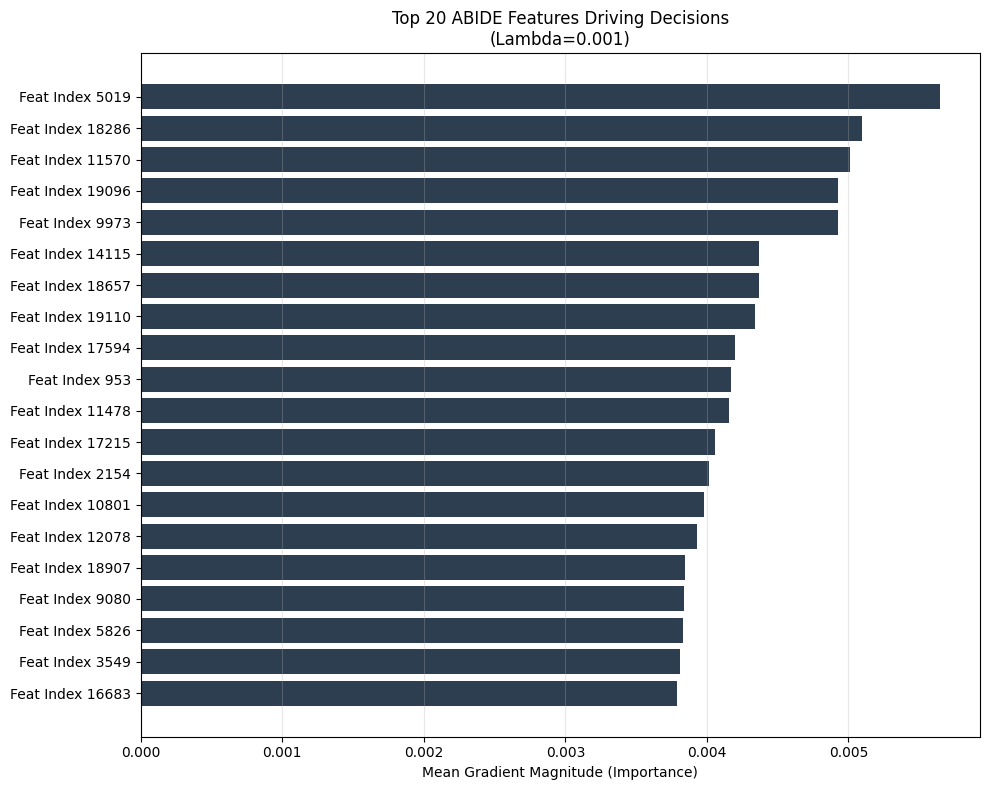


Model Sparsity Analysis:
Total Input Weights: 1273600
Effectively Zero Weights: 40390
Sparsity: 3.17% of connections were removed by L1.


In [ ]:
import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ============================================================================
# 0. REPRODUCIBILITY SETUP (CRITICAL FOR RESEARCH)
# ============================================================================
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds()
print(f"Random State locked to Seed: {SEED}")

# ============================================================================
# BLOCK 6: L1-REGULARIZED DNN (SPARSE MODEL)
# ============================================================================
print("\n" + "="*80)
print("BLOCK 6: HIGH-DIMENSIONAL L1 DNN TUNING")
print("Strategy: Grid Search L1 Lambda only. Fixed robust params for 19k features.")
print("="*80)

def build_l1_dnn(input_dim, l1_lambda=0.001):
    """
    DNN optimized for High-Dim/Low-Sample data.
    - High Dropout (0.5) to prevent memorization.
    - L1 Regularization to force feature sparsity.
    """
    init = tf.keras.initializers.GlorotUniform(seed=SEED)

    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        # Layer 1: The bottleneck. 19,900 -> 64
        layers.Dense(64, activation="relu", kernel_initializer=init,
                     kernel_regularizer=regularizers.l1(l1_lambda)),
        layers.Dropout(0.5, seed=SEED), # High dropout for 19k features

        # Layer 2: Deep processing
        layers.Dense(32, activation="relu", kernel_initializer=init,
                     kernel_regularizer=regularizers.l1(l1_lambda)),
        layers.Dropout(0.5, seed=SEED),

        layers.Dense(1, activation="sigmoid", kernel_initializer=init)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Lower LR for stability
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ---------------------------------------------------------
# 1. LAMBDA GRID SEARCH
# ---------------------------------------------------------
print("\nStarting L1 Lambda Grid Search...")

# Range adapted for 19,000 features.
# We need to find the balance between "Too much noise" (low lambda)
# and "Killing the model" (high lambda).
lambda_grid = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01]

best_acc = 0.0
best_lambda = lambda_grid[0]
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

results = {}

for l1_val in lambda_grid:
    fold_accs = []
    print(f"Testing Lambda: {l1_val}...", end=" ")

    for train_idx, val_idx in cv.split(X_dev, y_dev):
        set_seeds(SEED)

        X_tr, X_val = X_dev[train_idx], X_dev[val_idx]
        y_tr, y_val = y_dev[train_idx], y_dev[val_idx]

        # Scale
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        # Build & Train
        model = build_l1_dnn(X_tr_s.shape[1], l1_lambda=l1_val)

        # Early stopping is crucial here
        es = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=15, restore_best_weights=True, verbose=0)

        model.fit(X_tr_s, y_tr, epochs=100, batch_size=16,
                  verbose=0, validation_data=(X_val_s, y_val), callbacks=[es])

        # Score
        val_pred = (model.predict(X_val_s, verbose=0) > 0.5).astype(int)
        fold_accs.append(accuracy_score(y_val, val_pred))

    mean_acc = np.mean(fold_accs)
    results[l1_val] = mean_acc
    print(f"-> Mean Acc: {mean_acc:.4f}")

    if mean_acc > best_acc:
        best_acc = mean_acc
        best_lambda = l1_val

print(f"\n✓ Tuning Complete. Best Lambda: {best_lambda} (Acc: {best_acc:.4f})")

# ---------------------------------------------------------
# 2. FINAL MODEL TRAINING
# ---------------------------------------------------------
print(f"\nTraining Final Model (Lambda={best_lambda}) on full Dev Set...")
set_seeds(SEED)

scaler_final = StandardScaler()
X_dev_s = scaler_final.fit_transform(X_dev)
X_test_s = scaler_final.transform(X_test)

final_model = build_l1_dnn(X_dev_s.shape[1], l1_lambda=best_lambda)

es_final = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)

history = final_model.fit(
    X_dev_s, y_dev,
    validation_split=0.15,
    epochs=100,
    batch_size=16,
    verbose=1,
    callbacks=[es_final]
)

# ---------------------------------------------------------
# 3. EVALUATION
# ---------------------------------------------------------
y_prob_test = final_model.predict(X_test_s, verbose=0).ravel()
y_pred_test = (y_prob_test > 0.5).astype(int)

print("\n" + "="*30)
print("FINAL TEST RESULTS")
print("="*30)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_prob_test):.4f}")
print(classification_report(y_test, y_pred_test))

# ---------------------------------------------------------
# 4. SALIENCY MAP (EXPLAINABILITY)
# ---------------------------------------------------------
print("\nGenerating Saliency Maps for 19,900 features...")

def compute_saliency_map(model, X_data):
    images = tf.convert_to_tensor(X_data, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
    grads = tape.gradient(preds, images)
    return tf.reduce_mean(tf.abs(grads), axis=0).numpy()

# Compute
# We use a subset of X_test_s if memory is an issue, but 849 samples is fine for modern RAM
saliency = compute_saliency_map(final_model, X_test_s)

# Get Top 20 Features
top_n = 20
# Get indices of the top N features with highest gradients
top_indices = np.argsort(saliency)[-top_n:]
top_values = saliency[top_indices]

plt.figure(figsize=(10, 8))
plt.barh(range(top_n), top_values, color='#2c3e50')
plt.yticks(range(top_n), [f"Feat Index {i}" for i in top_indices])
plt.xlabel("Mean Gradient Magnitude (Importance)")
plt.title(f"Top 20 ABIDE Features Driving Decisions\n(Lambda={best_lambda})")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 5. SPARSITY CHECK
# ---------------------------------------------------------
# See how many of the 19,900 weights were forced to zero
weights_layer1 = final_model.layers[0].get_weights()[0]
# We use a small epsilon because float32 is rarely exactly 0.0
dead_neurons = np.sum(np.abs(weights_layer1) < 1e-5)
total_weights = weights_layer1.size
sparsity_ratio = (dead_neurons / total_weights) * 100

print(f"\nModel Sparsity Analysis:")
print(f"Total Input Weights: {total_weights}")
print(f"Effectively Zero Weights: {dead_neurons}")
print(f"Sparsity: {sparsity_ratio:.2f}% of connections were removed by L1.")

##7. DNN + RFE


BLOCK 7: DNN + RFE (NON-LINEAR SELECTION)
Strategy: Use Random Forest RFE to find complex features -> Train DNN
Tuning: Grid Searching optimal feature count (500 vs 1000 vs 2000)
Starting RFE Tuning on 19900 features...
(Note: This step takes time as it recursively removes features)

Testing Top 500 Features... -> Accuracy: 0.6134

Testing Top 1000 Features... -> Accuracy: 0.6639

Testing Top 2000 Features... -> Accuracy: 0.6891

✓ Best Feature Count: 2000 (Acc: 0.6891)

Training Final Model using Top 2000 features...
Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.5565 - loss: 2.6058 - val_accuracy: 0.6222 - val_loss: 2.3263
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6851 - loss: 2.2226 - val_accuracy: 0.6667 - val_loss: 2.2368
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7484 - loss: 2.0499 - val_accuracy: 0.7000 - val_loss: 2.1458
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7849 - loss: 1.9384 - val_accura

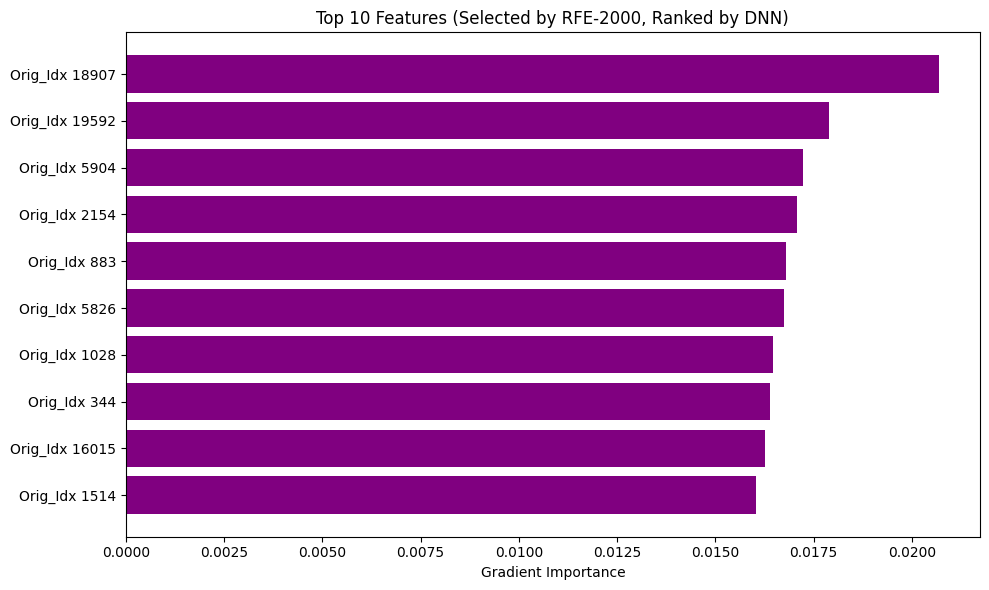

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ============================================================================
# 0. REPRODUCIBILITY SETUP
# ============================================================================
SEED = 42
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds()

# ============================================================================
# BLOCK 7: DNN + RFE (RECURSIVE FEATURE ELIMINATION)
# ============================================================================
print("\n" + "="*70)
print("BLOCK 7: DNN + RFE (NON-LINEAR SELECTION)")
print("Strategy: Use Random Forest RFE to find complex features -> Train DNN")
print("Tuning: Grid Searching optimal feature count (500 vs 1000 vs 2000)")
print("="*70)

# 1. Define the DNN Builder (Optimized for ~1000 features)
def build_rfe_dnn(input_dim):
    init = tf.keras.initializers.GlorotUniform(seed=SEED)

    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        # Denser architecture since features are now high-quality
        layers.Dense(64, activation="relu", kernel_initializer=init,
                     kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5, seed=SEED),

        layers.Dense(32, activation="relu", kernel_initializer=init,
                     kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3, seed=SEED),

        layers.Dense(1, activation="sigmoid", kernel_initializer=init)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

# 2. RFE Tuning Loop
# ---------------------------------------------------------
# We test 3 different feature counts to see which gives best DNN performance
FEATURES_TO_TEST = [500, 1000, 2000]
best_acc = 0
best_n_features = 1000
results = {}

# Pre-scale data (RFE needs scaled data)
scaler = StandardScaler()
X_dev_s = scaler.fit_transform(X_dev)
X_test_s = scaler.transform(X_test)

# We use a simple Validation split for tuning to save time (RFE is slow)
# Split Dev into Train/Tune
from sklearn.model_selection import train_test_split
X_tune_tr, X_tune_val, y_tune_tr, y_tune_val = train_test_split(
    X_dev_s, y_dev, test_size=0.2, stratify=y_dev, random_state=SEED
)

print(f"Starting RFE Tuning on {X_tune_tr.shape[1]} features...")
print("(Note: This step takes time as it recursively removes features)")

for n_feats in FEATURES_TO_TEST:
    print(f"\nTesting Top {n_feats} Features...", end=" ")

    # REPLACEMENT FOR LOGISTIC REGRESSION:
    # We use Random Forest (max_depth=5 for speed) to rank features
    # step=0.2 means we remove 20% of features per iteration (Aggressive/Fast)
    rfe_selector = RFE(
        estimator=RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=SEED),
        n_features_to_select=n_feats,
        step=0.2
    )

    # Fit RFE
    X_tr_rfe = rfe_selector.fit_transform(X_tune_tr, y_tune_tr)
    X_val_rfe = rfe_selector.transform(X_tune_val)

    # Train DNN on this subset
    model = build_rfe_dnn(X_tr_rfe.shape[1])

    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
    model.fit(X_tr_rfe, y_tune_tr, validation_data=(X_val_rfe, y_tune_val),
              epochs=40, batch_size=16, verbose=0, callbacks=[es])

    # Evaluate
    val_pred = (model.predict(X_val_rfe, verbose=0) > 0.5).astype(int)
    acc = accuracy_score(y_tune_val, val_pred)

    results[n_feats] = acc
    print(f"-> Accuracy: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_n_features = n_feats

print(f"\n✓ Best Feature Count: {best_n_features} (Acc: {best_acc:.4f})")

# 3. Final Model Training
# ---------------------------------------------------------
print(f"\nTraining Final Model using Top {best_n_features} features...")

# Run RFE one last time on FULL Dev set
final_rfe = RFE(
    estimator=RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=SEED),
    n_features_to_select=best_n_features,
    step=0.2
)

X_dev_final = final_rfe.fit_transform(X_dev_s, y_dev)
X_test_final = final_rfe.transform(X_test_s)

# Train Final DNN
final_model = build_rfe_dnn(X_dev_final.shape[1])

es_final = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

history = final_model.fit(
    X_dev_final, y_dev,
    validation_split=0.15,
    epochs=60,
    batch_size=16,
    verbose=1,
    callbacks=[es_final]
)

# 4. Evaluation
# ---------------------------------------------------------
y_prob = final_model.predict(X_test_final, verbose=0).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("\n" + "="*40)
print(f"FINAL TEST RESULTS (RFE-{best_n_features} + DNN)")
print("="*40)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_test, y_prob):.4f}")
print(classification_report(y_test, y_pred))

# 5. Feature Visualization (Saliency on Reduced Set)
# ---------------------------------------------------------
print("\nGenerating Saliency Map for Selected Features...")

# Get gradients
images = tf.convert_to_tensor(X_test_final, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(images)
    preds = final_model(images)
grads = tape.gradient(preds, images)
saliency = tf.reduce_mean(tf.abs(grads), axis=0).numpy()

# Map back to original indices
support_mask = final_rfe.get_support() # Boolean mask of 19,900 features
original_indices = np.where(support_mask)[0] # Indices kept by RFE

# Get Top 10
top_k_idx = np.argsort(saliency)[-10:]
top_original_indices = original_indices[top_k_idx]
top_values = saliency[top_k_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(10), top_values, color='purple')
plt.yticks(range(10), [f"Orig_Idx {i}" for i in top_original_indices])
plt.xlabel("Gradient Importance")
plt.title(f"Top 10 Features (Selected by RFE-{best_n_features}, Ranked by DNN)")
plt.tight_layout()
plt.show()

## 8. Random Forest

STARTING RANDOM FOREST ANALYSIS
Error loading data: File not found at: /content/drive/MyDrive/ABIDE/ABIDE_CC200_FINAL_NO_NAN.csv
Creating dummy data for demonstration...
Development Set: (140, 100)
Test Set:        (60, 100)

Running Random Forest 5-Fold CV........ Done.
====== Random Forest 5-Fold CV Results ======
Mean Accuracy:  0.4786 ± 0.1508
Mean Precision: 0.4805 ± 0.1415
Mean F1 Score:  0.4931 ± 0.1572
Mean AUC:       0.4808 ± 0.1654

Training Final Model on Full Development Set...

====== RANDOM FOREST FINAL TEST RESULTS (30% Hold-out) ======
Test Accuracy:  0.5667
Test Precision: 0.5714
Test F1 Score:  0.5517
Test AUC:       0.5667


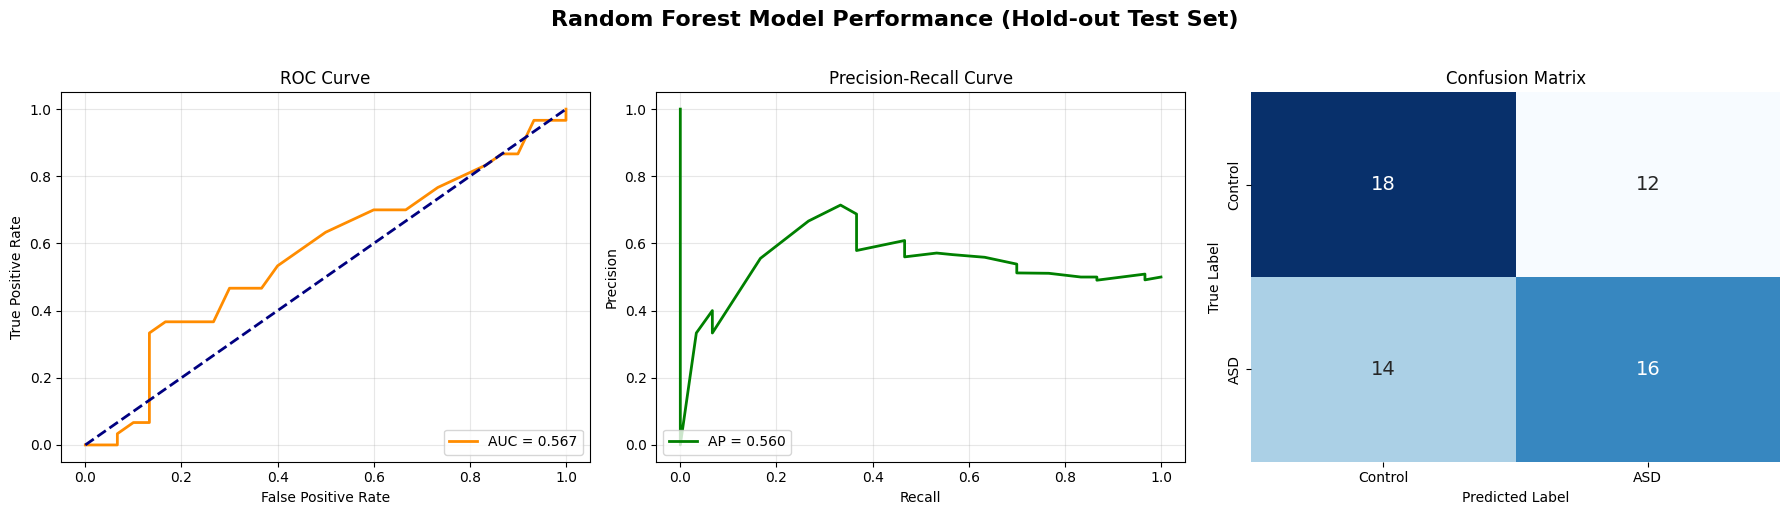


FEATURE IMPORTANCE (Gini Impurity / Tree Saliency)


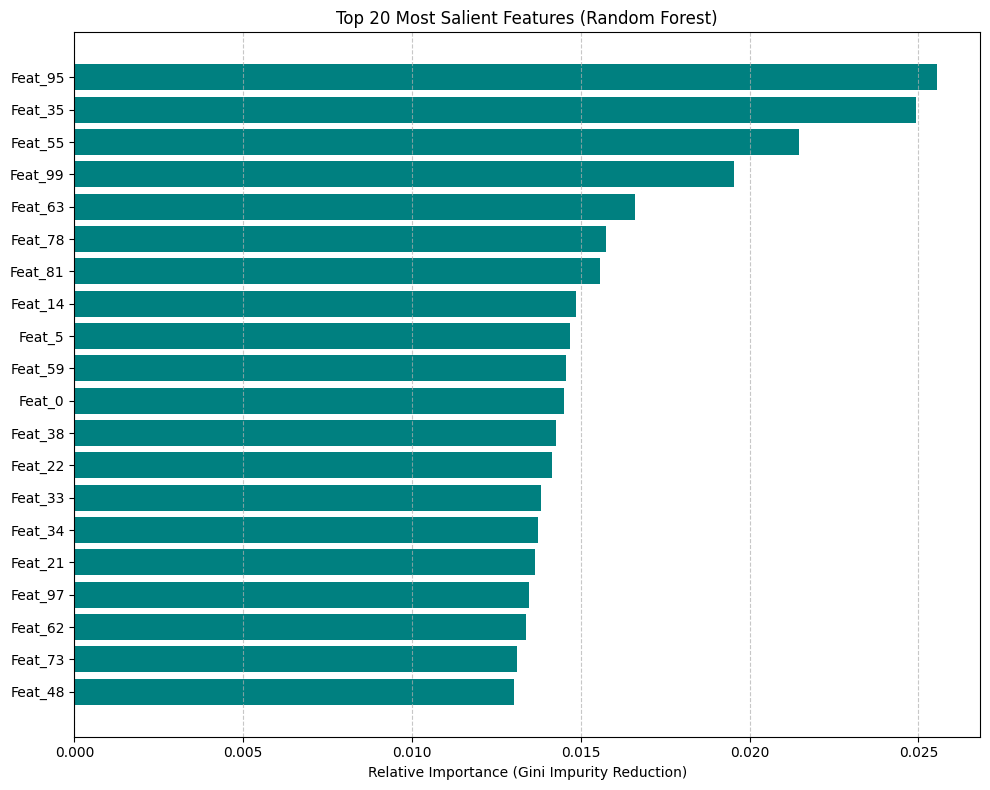

Note: For Random Forests, 'Importance' is calculated based on how much
each feature decreases weighted impurity across all trees in the forest.


In [ ]:
# ============================================================================
# STANDALONE BLOCK: RANDOM FOREST CLASSIFIER (WITH FEATURE IMPORTANCE)
# ============================================================================

# 1. IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import random

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             precision_score, confusion_matrix,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)

warnings.filterwarnings('ignore')
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)


# 2. GLOBAL SETUP (REPRODUCIBILITY)
SEED = 42

def set_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(SEED)

# 3. DATA LOADING
def load_and_preprocess_data(filepath):
    """Load ABIDE dataset and perform initial preprocessing"""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found at: {filepath}")

    df = pd.read_csv(filepath)

    # Label Encoding (2 -> 0 for Control, 1 -> 1 for ASD)
    if 2 in df["DX_GROUP"].values:
        df["DX_GROUP"] = df["DX_GROUP"].replace({2: 0, 1: 1})

    X = df.drop(["SUB_ID", "DX_GROUP"], axis=1, errors='ignore').values
    y = df["DX_GROUP"].values
    feature_names = df.drop(["SUB_ID", "DX_GROUP"], axis=1).columns

    return X, y, feature_names

# 4. HELPER FUNCTIONS
def plot_performance_metrics(y_test, y_pred_test, y_prob_test, title_prefix="Model"):
    """Create 3-panel visualization: ROC, PR Curve, and Confusion Matrix"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.suptitle(f"{title_prefix} Performance (Hold-out Test Set)",
                 fontsize=16, fontweight='bold', y=1.02)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    roc_auc_val = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_val:.3f}')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend(loc="lower right")
    axes[0].grid(alpha=0.3)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob_test)
    avg_precision = average_precision_score(y_test, y_prob_test)
    axes[1].plot(recall, precision, color='green', lw=2, label=f'AP = {avg_precision:.3f}')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend(loc="lower left")
    axes[1].grid(alpha=0.3)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2], cbar=False,
                xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'],
                annot_kws={"size": 14})
    axes[2].set_title('Confusion Matrix')
    axes[2].set_ylabel('True Label')
    axes[2].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

def evaluate_test_set(model, X_test, y_test):
    """Evaluate model on test set and return metrics"""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'auc': roc_auc_score(y_test, y_prob)
    }
    return y_pred, y_prob, metrics

def print_test_results(metrics, title="FINAL TEST RESULTS"):
    print(f"\n====== {title} (30% Hold-out) ======")
    print(f"Test Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Test Precision: {metrics['precision']:.4f}")
    print(f"Test F1 Score:  {metrics['f1']:.4f}")
    print(f"Test AUC:       {metrics['auc']:.4f}")

def run_cross_validation(X_data, y_data, model_pipeline_func, k_folds, name):
    """Generic cross-validation runner"""
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=SEED)
    metrics = {'acc': [], 'prec': [], 'f1': [], 'auc': []}

    print(f"\nRunning {name}...", end="")
    for i, (train_idx, val_idx) in enumerate(cv.split(X_data, y_data)):
        X_tr, X_val = X_data[train_idx], X_data[val_idx]
        y_tr, y_val = y_data[train_idx], y_data[val_idx]

        model, X_val_transformed = model_pipeline_func(X_tr, y_tr, X_val)

        y_pred = model.predict(X_val_transformed)
        y_prob = model.predict_proba(X_val_transformed)[:, 1]

        metrics['acc'].append(accuracy_score(y_val, y_pred))
        metrics['prec'].append(precision_score(y_val, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_val, y_pred, zero_division=0))
        metrics['auc'].append(roc_auc_score(y_val, y_prob))
        print(".", end="")

    print(" Done.")
    print(f"====== {name} Results ======")
    print(f"Mean Accuracy:  {np.mean(metrics['acc']):.4f} ± {np.std(metrics['acc']):.4f}")
    print(f"Mean Precision: {np.mean(metrics['prec']):.4f} ± {np.std(metrics['prec']):.4f}")
    print(f"Mean F1 Score:  {np.mean(metrics['f1']):.4f} ± {np.std(metrics['f1']):.4f}")
    print(f"Mean AUC:       {np.mean(metrics['auc']):.4f} ± {np.std(metrics['auc']):.4f}")

# 5. MODEL PIPELINE
def rf_pipeline(X_train, y_train, X_val):
    """Scale + Train Random Forest"""
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)

    model = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    model.fit(X_train_s, y_train)

    return model, X_val_s

# ============================================================================
# MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":
    print("="*60)
    print("STARTING RANDOM FOREST ANALYSIS")
    print("="*60)

    # --- A. Load Data ---
    filepath = "/content/drive/MyDrive/ABIDE/ABIDE_CC200_FINAL_NO_NAN.csv"

    try:
        X, y, feature_names = load_and_preprocess_data(filepath)
        print("Data loaded successfully.")
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Creating dummy data for demonstration...")
        X = np.random.rand(200, 100)
        y = np.random.randint(0, 2, 200)
        feature_names = pd.Index([f"Feat_{i}" for i in range(100)])

    # --- B. Split Data ---
    X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=SEED
    )

    print(f"Development Set: {X_dev.shape}")
    print(f"Test Set:        {X_test.shape}")

    # --- C. Cross-Validation ---
    run_cross_validation(X_dev, y_dev, rf_pipeline, k_folds=5,
                        name="Random Forest 5-Fold CV")

    # --- D. Final Training ---
    print("\nTraining Final Model on Full Development Set...")
    scaler_final = StandardScaler()
    X_dev_s = scaler_final.fit_transform(X_dev)
    X_test_s = scaler_final.transform(X_test)

    model_final = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    model_final.fit(X_dev_s, y_dev)

    # --- E. Evaluation ---
    y_pred_test, y_prob_test, metrics = evaluate_test_set(model_final, X_test_s, y_test)
    print_test_results(metrics, "RANDOM FOREST FINAL TEST RESULTS")

    # --- F. Visualization ---
    plot_performance_metrics(y_test, y_pred_test, y_prob_test, "Random Forest Model")

    # --- G. FEATURE IMPORTANCE (Tree-based "Saliency") ---
    print("\n" + "="*50)
    print("FEATURE IMPORTANCE (Gini Impurity / Tree Saliency)")
    print("="*50)

    # 1. Extract Feature Importances
    # This is the Random Forest equivalent of a Saliency Map
    importances = model_final.feature_importances_

    # 2. Identify Top 20 Features
    top_n = 20
    indices = np.argsort(importances)[-top_n:] # Sort and take last 20

    # 3. Prepare Plotting Data
    top_values = importances[indices]
    top_labels = [feature_names[i] for i in indices]

    # 4. Plot
    plt.figure(figsize=(10, 8))
    # Use a horizontal bar chart (barh) which is standard for "Saliency"
    plt.barh(range(len(indices)), top_values, color='teal', align='center')
    plt.yticks(range(len(indices)), top_labels)
    plt.xlabel("Relative Importance (Gini Impurity Reduction)")
    plt.title(f"Top {top_n} Most Salient Features (Random Forest)")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("Note: For Random Forests, 'Importance' is calculated based on how much")
    print("each feature decreases weighted impurity across all trees in the forest.")